<a href="https://colab.research.google.com/github/sikha2552/Meta-UNet/blob/main/Ham1000SIC__MCD_Jaccard__Metal_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [ ]:
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, concatenate, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras.layers import SpatialDropout2D
from keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
np.random.seed(101)

## Download dataset from Kaggle

In [ ]:
# Install Kaggle API
!pip install -q kaggle

# Upload your kaggle.json API key
from google.colab import files
files.upload()  # Upload kaggle.json

# Move key to proper location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d volodymyrpivoshenko/skin-cancer-lesions-segmentation

# Unzip dataset
!unzip -q skin-cancer-lesions-segmentation.zip -d ham10000

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/volodymyrpivoshenko/skin-cancer-lesions-segmentation
License(s): CC-BY-NC-SA-4.0


## Split data to train and test


In [ ]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split

# ====================
# Configuration
# ====================
dataset_root = '/content/ham10000/data'
image_dir = os.path.join(dataset_root, 'images')
mask_dir = os.path.join(dataset_root, 'masks')
metadata_path = os.path.join(dataset_root, 'metadata.csv')

# Output directories
output_dirs = ['Train_X', 'Train_Y', 'Test_X', 'Test_Y']
for dir in output_dirs:
    os.makedirs(dir, exist_ok=True)

# ====================
# Load and prepare metadata
# ====================
# Load metadata with proper column names
df = pd.read_csv(metadata_path)
lesion_columns = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

# Create diagnosis column for stratification
df['diagnosis'] = df[lesion_columns].idxmax(axis=1)

# ====================
# Split dataset
# ====================
# Stratified train-test split
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['diagnosis'],
    random_state=42
)

# ====================
# Organize files function
# ====================
def organize_files(df, image_dest, mask_dest):
    for _, row in df.iterrows():
        img_id = row['image']

        # Original paths
        img_src = os.path.join(image_dir, f"{img_id}.jpg")
        mask_src = os.path.join(mask_dir, f"{img_id}.png")

        # Destination paths
        img_dest_path = os.path.join(image_dest, f"{img_id}.jpg")
        mask_dest_path = os.path.join(mask_dest, f"{img_id}_mask.png")

        # Copy files
        shutil.copy(img_src, img_dest_path)
        shutil.copy(mask_src, mask_dest_path)

# ====================
# Execute organization
# ====================
# Process training set
organize_files(train_df, 'Train_X', 'Train_Y')

# Process test set
organize_files(test_df, 'Test_X', 'Test_Y')

# ====================
# Save metadata splits
# ====================
train_df.to_csv('meta_train.csv', index=False)
test_df.to_csv('meta_test.csv', index=False)

print("Dataset successfully split!")
print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Class distribution:\n{train_df['diagnosis'].value_counts()}")

Dataset successfully split!
Training samples: 8012
Test samples: 2003
Class distribution:
diagnosis
NV       5364
MEL       890
BKL       879
BCC       411
AKIEC     262
VASC      114
DF         92
Name: count, dtype: int64


## Upload images

In [ ]:
import numpy as np
import cv2
import glob
import os
train_path = '/content/Train_X/*.jpg'
ground_truth_path = '/content/Train_Y/*.png'
test_path = '/content/Test_X/*.jpg'
test_gt = '/content/Test_Y/*.png'
def numericalSort(value):
    import re
    numbers = re.compile(r'(\d+)')
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

# Desired shape for the images
TARGET_SHAPE = (128, 128)  # Adjust based on your input requirements

# Get and sort file lists
filelist_trainx = sorted(glob.glob(train_path), key=numericalSort)
filelist_trainy = sorted(glob.glob(ground_truth_path), key=numericalSort)
filelist_testx = sorted(glob.glob(test_path), key=numericalSort)
filelist_testy = sorted(glob.glob(test_gt), key=numericalSort)
from tqdm import tqdm

X_train = np.array([cv2.resize(cv2.imread(fname), TARGET_SHAPE) for fname in tqdm(filelist_trainx, desc="Loading X_train")])
Y_train = np.array([cv2.resize(cv2.imread(fname, cv2.IMREAD_GRAYSCALE), TARGET_SHAPE) for fname in tqdm(filelist_trainy, desc="Loading Y_train")])
X_test = np.array([cv2.resize(cv2.imread(fname), TARGET_SHAPE) for fname in tqdm(filelist_testx, desc="Loading X_test")])
Y_test = np.array([cv2.resize(cv2.imread(fname, cv2.IMREAD_GRAYSCALE), TARGET_SHAPE) for fname in tqdm(filelist_testy, desc="Loading Y_test")])


print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")


Loading Y_test: 100%|██████████| 2003/2003 [00:01<00:00, 1754.22it/s]

X_train shape: (8012, 128, 128, 3)
Y_train shape: (8012, 128, 128)
X_test shape: (2003, 128, 128, 3)
Y_test shape: (2003, 128, 128)


## Preprocess images and Masks

In [ ]:
# Normalize images (input images to [0,1])
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Normalize masks (ground truth masks)
Y_train = Y_train.astype('float32') / 255.0
Y_test = Y_test.astype('float32') / 255.0
Y_train = (Y_train > 0.5).astype('float32')
Y_test = (Y_test > 0.5).astype('float32')


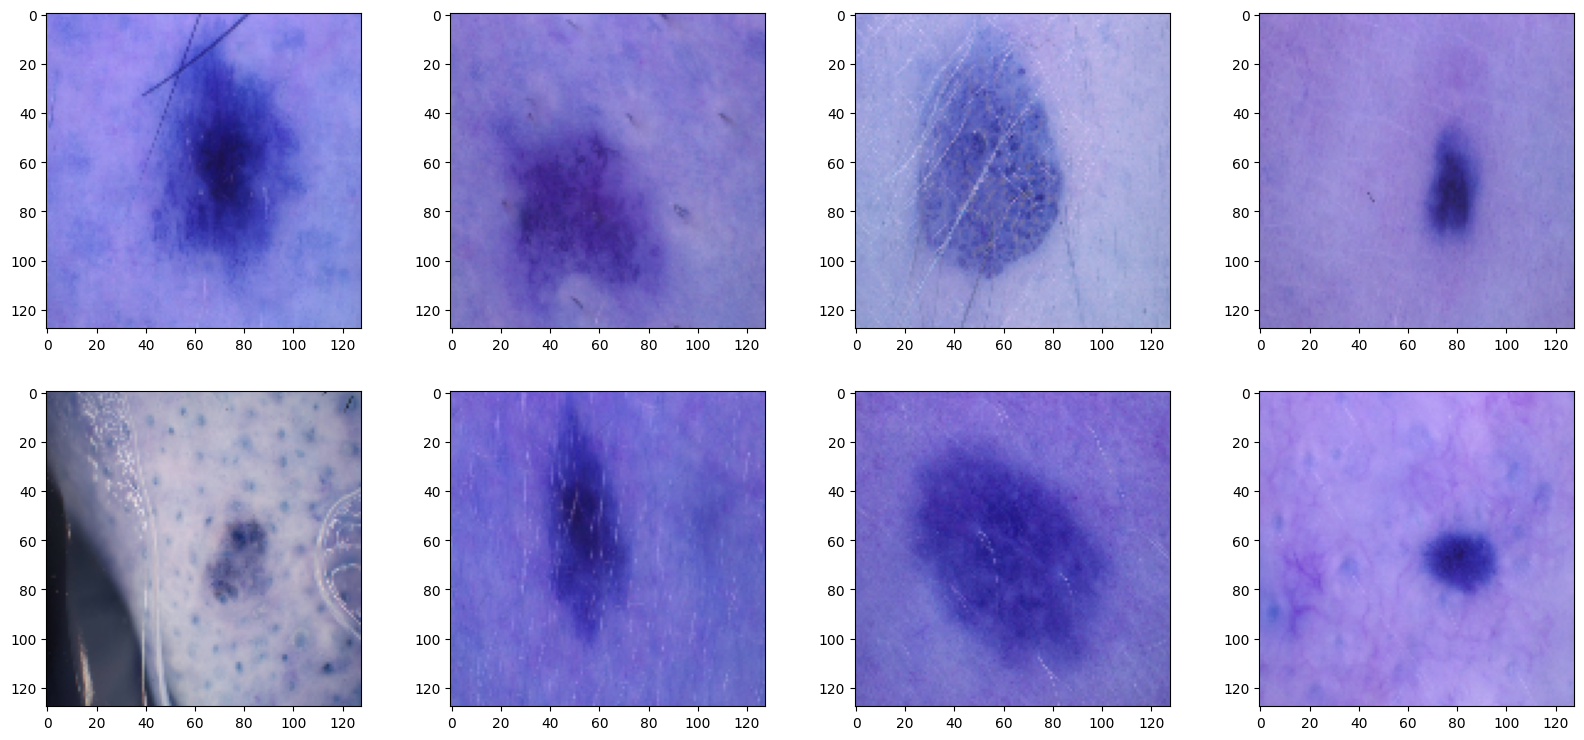

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(X_train[0])
plt.subplot(2,4,2)
plt.imshow(X_train[3])
plt.subplot(2,4,3)
plt.imshow(X_train[54])
plt.subplot(2,4,4)
plt.imshow(X_train[77])
plt.subplot(2,4,5)
plt.imshow(X_train[100])
plt.subplot(2,4,6)
plt.imshow(X_train[125])
plt.subplot(2,4,7)
plt.imshow(X_train[130])
plt.subplot(2,4,8)
plt.imshow(X_train[149])
plt.show()

## Define Metrices

In [ ]:
def jaccard_distance(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=-1)
    sum_ = tf.reduce_sum(tf.square(y_true), axis=-1) + tf.reduce_sum(tf.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return 1 - jac

def iou(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=-1)
    sum_ = tf.reduce_sum(tf.square(y_true), axis=-1) + tf.reduce_sum(tf.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def dice_coe(y_true, y_pred,smooth=1e-6):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def precision(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    return true_positives / (predicted_positives + tf.keras.backend.epsilon())

def recall(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

def accuracy(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    return tf.reduce_mean(tf.cast(tf.equal(y_true, tf.round(y_pred)), tf.float32))

# Process Meta Data

In [ ]:
import pandas as pd
# Load Meta data
file_path = '/content/meta_train.csv'
med_data_raw = pd.read_csv(file_path)
print(f"Length of metadata: {len(med_data_raw)}")
file_path_test='/content/meta_test.csv'
med_data_test = pd.read_csv(file_path_test)
print(f"Length of metadata: {len(med_data_test)}")


Length of metadata: 8012
Length of metadata: 2003


In [ ]:
print(f"Length of x_train: {len(X_train)}")
print(f"Length of y_train: {len(Y_train)}")
print(f"Length of med_data_raw: {len(med_data_raw)}")
print(f"Length of med_data_raw: {len(med_data_test)}")


Length of x_train: 8012
Length of y_train: 8012
Length of med_data_raw: 8012
Length of med_data_raw: 2003


In [ ]:
# Image Augmentation byconsidering meta data
# def random_rotation(x_image, y_image):
#     rows_x,cols_x, chl_x = x_image.shape
#     rows_y,cols_y = y_image.shape
#     rand_num = np.random.randint(-40,40)
#     M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
#     M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
#     x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
#     y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
#     return x_image, y_image.astype('int')

# def horizontal_flip(x_image, y_image):
#     x_image = cv2.flip(x_image, 1)
#     y_image = cv2.flip(y_image.astype('float32'), 1)
#     return x_image, y_image.astype('int')
# def img_augmentation(x_train, y_train, metadata_train):
#     x_rotat, y_rotat, metadata_rotat = [], [], []
#     x_flip, y_flip, metadata_flip = [], [], []

#     for idx in range(len(x_train)):
#         x, y = random_rotation(x_train[idx], y_train[idx])
#         x_rotat.append(x)
#         y_rotat.append(y)
#         metadata_rotat.append(metadata_train.iloc[idx])  # Preserve row structure

#         x, y = horizontal_flip(x_train[idx], y_train[idx])
#         x_flip.append(x)
#         y_flip.append(y)
#         metadata_flip.append(metadata_train.iloc[idx])  # Preserve row structure

#     # Convert augmented metadata back to DataFrame
#     metadata_rotat_df = pd.DataFrame(metadata_rotat, columns=metadata_train.columns)
#     metadata_flip_df = pd.DataFrame(metadata_flip, columns=metadata_train.columns)

#     return np.array(x_rotat), np.array(y_rotat), metadata_rotat_df, np.array(x_flip), np.array(y_flip), metadata_flip_df



In [ ]:
# x_rotat, y_rotat, metadata_rotat_df, x_flip, y_flip, metadata_flip_df = img_augmentation(X_train, Y_train, med_data_raw)

# # Combine original and augmented data
# x_train_augmented = np.concatenate([X_train, x_rotat, x_flip], axis=0)
# y_train_augmented = np.concatenate([Y_train, y_rotat, y_flip], axis=0)
# metadata_train_augmented = pd.concat([med_data_raw, metadata_rotat_df, metadata_flip_df], axis=0)


In [ ]:
x_train_full = X_train#x_train_augmented
y_train_full = Y_train#y_train_augmented
metadata_train_augmented=med_data_raw
print(x_train_full.shape)
print(y_train_full.shape)
print(f"Length of metadata_train_augmented: {len(metadata_train_augmented)}")


(8012, 128, 128, 3)
(8012, 128, 128)
Length of metadata_train_augmented: 8012


## Split dataset

In [ ]:
from sklearn.model_selection import train_test_split

# Split the augmented data into training and validation sets
x_train, x_val, y_train, y_val, metadata_train, metadata_val = train_test_split(
    x_train_full,
    y_train_full,
    metadata_train_augmented,  # Include metadata here
    test_size=0.20,
    random_state=101
)

print("Length of the Training Set   : {}".format(len(x_train)))
print("Length of the Validation Set : {}".format(len(x_val)))
print("Length of the Metadata Training Set : {}".format(len(metadata_train)))
print("Length of the Metadata Validation Set : {}".format(len(metadata_val)))

Length of the Training Set   : 6409
Length of the Validation Set : 1603
Length of the Metadata Training Set : 6409
Length of the Metadata Validation Set : 1603


## MEta data embedding

In [ ]:
from tensorflow.keras.layers import Embedding, Flatten, Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import UpSampling2D, Conv2D, Activation, MaxPooling2D, SpatialDropout2D
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Define the updated metadata columns
metadata_columns = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

# Encode metadata columns
metadata_encoders = {
    col: LabelEncoder().fit(metadata_train[col].astype(str)) for col in metadata_columns
}

# Encode training metadata
encoded_metadata_train = np.column_stack([
    metadata_encoders[col].transform(metadata_train[col].astype(str)) for col in metadata_columns
])

# Encode validation metadata
encoded_metadata_val = np.column_stack([
    metadata_encoders[col].transform(metadata_val[col].astype(str)) for col in metadata_columns
])



In [ ]:
#Apply Embeddings:
import re

embedding_sizes = {col: min(50, len(metadata_encoders[col].classes_)) for col in metadata_columns}
metadata_inputs = []
metadata_embeddings = []
for col, input_dim in embedding_sizes.items():
    input_layer = Input(shape=(1,), name=f"{col}_input")
    embedding_layer = Embedding(input_dim=input_dim, output_dim=embedding_sizes[col], name=f"{col}_embedding")(input_layer)
    flattened_layer = Flatten()(embedding_layer)
    metadata_inputs.append(input_layer)
    metadata_embeddings.append(flattened_layer)

In [ ]:
# Concatenate all metadata embeddings
metadata_combined = Concatenate()(metadata_embeddings)
metadata_dense = Dense(128, activation='relu')(metadata_combined)
metadata_dense = Dense(64, activation='relu')(metadata_dense)

In [ ]:


# Check again after normalization
print("Min value of X_train:", np.min(X_train))
print("Max value of X_train:", np.max(X_train))

print("Min value of X_test:", np.min(X_test))
print("Max value of X_test:", np.max(X_test))


Min value of X_train: 0.0
Max value of X_train: 1.0
Min value of X_test: 0.0
Max value of X_test: 1.0


In [ ]:
# Check unique values in Y_train
print("Unique values in Y_train:", np.unique(Y_train))

# Check unique values in Y_test
print("Unique values in Y_test:", np.unique(Y_test))


Unique values in Y_train: [0. 1.]
Unique values in Y_test: [0. 1.]


#The Model

In [ ]:
# Number of image channels (for example 3 in case of RGB, or 1 for grayscale images)
INPUT_CHANNELS = 3
# Number of output masks (1 in case you predict only one type of objects)
OUTPUT_MASK_CHANNELS = 1
# Pretrained weights

In [ ]:
from tensorflow.keras.layers import (
    Embedding, Flatten, Input, Dense, Concatenate, Reshape, Conv2D,
    Activation, MaxPooling2D, SpatialDropout2D, UpSampling2D, concatenate, BatchNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

def build_unet_with_metadata(img_shape, metadata_embedding_sizes, filters, dropout_val, OUTPUT_MASK_CHANNELS, epochs_num, x_train_images, x_train_metadata, y_train, x_val_images, x_val_metadata, y_val, savename):
    def double_conv_layer(x, size, dropout=0.40, batch_norm=True):
        if K.image_data_format() == 'channels_first':
            axis = 1
        else:
            axis = 3
        conv = Conv2D(size, (3, 3), padding='same')(x)
        if batch_norm:
            conv = BatchNormalization(axis=axis)(conv)
        conv = Activation('relu')(conv)
        conv = Conv2D(size, (3, 3), padding='same')(conv)
        if batch_norm:
            conv = BatchNormalization(axis=axis)(conv)
        conv = Activation('relu')(conv)
        if dropout > 0:
            conv = SpatialDropout2D(dropout)(conv)
        return conv

    # Image input
    img_inputs = Input(shape=img_shape, name="Image_Input")

    # Metadata inputs and embeddings
    metadata_inputs = []
    metadata_embeddings = []
    for col, input_dim in metadata_embedding_sizes.items():
        input_layer = Input(shape=(1,), name=f"{col}_input")
        embedding_layer = Embedding(input_dim=input_dim, output_dim=metadata_embedding_sizes[col], name=f"{col}_embedding")(input_layer)
        flattened_layer = Flatten()(embedding_layer)
        metadata_inputs.append(input_layer)
        metadata_embeddings.append(flattened_layer)

    # Combine metadata embeddings into a dense layer
    metadata_combined = Concatenate(name="Metadata_Concatenated")(metadata_embeddings)
    metadata_dense = Dense(128, activation="relu", name="Metadata_Dense")(metadata_combined)

    # Encoder
    conv_224 = double_conv_layer(img_inputs, filters)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)
    conv_112 = double_conv_layer(pool_112, 2 * filters)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)
    conv_56 = double_conv_layer(pool_56, 4 * filters)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)
    conv_28 = double_conv_layer(pool_28, 8 * filters)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)
    conv_14 = double_conv_layer(pool_14, 16 * filters)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)
    conv_7 = double_conv_layer(pool_7, 32 * filters)

    # Concatenate metadata with bottleneck features
    bottleneck = Flatten()(conv_7)
    combined_features = Concatenate(name="Bottleneck_Concat")([bottleneck, metadata_dense])

    # Decoder
    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=-1)
    up_conv_14 = double_conv_layer(up_14, 16 * filters)
    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=-1)
    up_conv_28 = double_conv_layer(up_28, 8 * filters)
    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=-1)
    up_conv_56 = double_conv_layer(up_56, 4 * filters)
    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=-1)
    up_conv_112 = double_conv_layer(up_112, 2 * filters)
    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=-1)
    up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

    # Final layer
    conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
    conv_final = Activation('sigmoid')(conv_final)
    pred = Reshape((img_shape[0], img_shape[1]))(conv_final)

    # Model
    model = Model(inputs=[img_inputs] + metadata_inputs, outputs=pred, name="UNET_224_with_Metadata")
    checkpoint = ModelCheckpoint(savename, monitor='val_loss', save_best_only=True, save_weights_only=True, mode='min', verbose=1)

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss= [jaccard_distance],  # Adjust this as needed
                  metrics=['accuracy',iou, dice_coe,])  # Add your custom metrics if required
    model.summary
    # Fit the model
    history = model.fit(   x=[x_train_images] + [encoded_metadata_train[:, i] for i in range(encoded_metadata_train.shape[1])],
    y=y_train,
    epochs=epochs_num,
    batch_size=32,
    validation_data=(
        [x_val_images] + [encoded_metadata_val[:, i] for i in range(encoded_metadata_val.shape[1])],
        y_val
    ),
    callbacks=[checkpoint],
    verbose=1
  )


    return model, history


## To load and test the model

In [ ]:
from tensorflow.keras import backend as K
import tensorflow as tf

# For Training
# Define parameters
img_shape = (128, 128, 3)  # Example image shape (adjust as needed)
metadata_embedding_sizes = {
    'MEL': 5,   # Example number of unique classes
    'NV': 5,
    'BCC': 5,
    'AKIEC': 5,
    'BKL': 5,
    'DF': 5,
    'VASC': 5,
}

filters = 32
dropout_val = 0.4
OUTPUT_MASK_CHANNELS = 1  # Assuming binary segmentation
epochs_num = 1

# Call the function
model = build_unet_with_metadata(
    img_shape=img_shape,
    metadata_embedding_sizes=metadata_embedding_sizes,
    filters=filters,
    dropout_val=dropout_val,
    OUTPUT_MASK_CHANNELS=OUTPUT_MASK_CHANNELS,
    epochs_num=epochs_num,
    x_train_images=x_train,
    x_train_metadata=metadata_train,
    y_train=y_train,
    x_val_images=x_val,
    x_val_metadata=metadata_val,
    y_val=y_val,
    savename='/content/drive/MyDrive/Alaysia/ISIC/weights/ham_mednet_200_new_epoch.weights.h5'
)



In [ ]:
model.summary()

Model: "UNET_224_with_Metadata"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Image_Input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ Image_Input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d   │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (SpatialDropout2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ spatial_dropout2… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_1 │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (SpatialDropout2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ spatial_dropout2

 Total params: 31,466,753 (120.04 MB)

 Trainable params: 31,454,721 (119.99 MB)

 Non-trainable params: 12,032 (47.00 KB)

In [ ]:
model.load_weights('/content/drive/MyDrive/Alaysia/ISIC/weights/ham10k_mednet_200_new_epoch.weights.h5')

In [ ]:
from tensorflow.keras import backend as K
import tensorflow as tf

# For Training
# Define parameters
img_shape = (128, 128, 3)  # Example image shape (adjust as needed)
metadata_embedding_sizes = {
    'MEL': 5,   # Example number of unique classes
    'NV': 5,
    'BCC': 5,
    'AKIEC': 5,
    'BKL': 5,
    'DF': 5,
    'VASC': 5,
}

filters = 32
dropout_val = 0.4
OUTPUT_MASK_CHANNELS = 1  # Assuming binary segmentation
epochs_num = 200

# Call the function
model, hist = build_unet_with_metadata(
    img_shape=img_shape,
    metadata_embedding_sizes=metadata_embedding_sizes,
    filters=filters,
    dropout_val=dropout_val,
    OUTPUT_MASK_CHANNELS=OUTPUT_MASK_CHANNELS,
    epochs_num=epochs_num,
    x_train_images=x_train,
    x_train_metadata=metadata_train,
    y_train=y_train,
    x_val_images=x_val,
    x_val_metadata=metadata_val,
    y_val=y_val,
    savename='/content/drive/MyDrive/Alaysia/ISIC/weights/ham10k_mednet_200_new_epoch.weights.h5'
)


In [ ]:
# Plot the training curve
import matplotlib.pyplot as plt
# Extract training loss and validation loss from history
training_loss = hist.history['loss']
validation_loss = hist.history['val_loss']
num_epochs=200
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), training_loss, label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Test the model

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Define the updated metadata columns
metadata_columns = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

# Encode metadata columns
metadata_encoders = {
    col: LabelEncoder().fit(med_data_test[col].astype(str)) for col in metadata_columns
}

# Encode training metadata
encoded_test_metadata = np.column_stack([
    metadata_encoders[col].transform(med_data_test[col].astype(str)) for col in metadata_columns
])

In [ ]:
# Debug shapes
print("x_test shape:", X_test.shape)
test_metadata_inputs = [encoded_test_metadata[:, i].reshape(-1, 1) for i in range(encoded_test_metadata.shape[1])]
for i, metadata in enumerate(test_metadata_inputs):
    print(f"Metadata input {i} shape:", metadata.shape)

# Predict masks
predictions = model.predict([X_test] + test_metadata_inputs)

# Binarize predictions
predictions_binary = (predictions > 0.5).astype(int)



x_test shape: (2003, 128, 128, 3)
Metadata input 0 shape: (2003, 1)
Metadata input 1 shape: (2003, 1)
Metadata input 2 shape: (2003, 1)
Metadata input 3 shape: (2003, 1)
Metadata input 4 shape: (2003, 1)
Metadata input 5 shape: (2003, 1)
Metadata input 6 shape: (2003, 1)
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step


In [ ]:
import numpy as np
from tensorflow.keras import backend as K

# Dice and IoU score functions
def dice_score(y_true, y_pred, smooth=1e-6):
    y_true = K.cast(y_true, dtype=K.floatx())
    y_pred = K.cast(y_pred, dtype=K.floatx())
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2. * intersection + smooth) / (union + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    y_true = K.cast(y_true, dtype=K.floatx())
    y_pred = K.cast(y_pred, dtype=K.floatx())
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)
# Calculate Dice and IoU scores
dice_scores = []
iou_scores = []

for i in range(len(Y_test)):
    y_true = Y_test[i]
    y_pred_bin = predictions_binary[i]

    y_true_tf = tf.constant(y_true, dtype=K.floatx())  # <-- FIXED
    y_pred_bin_tf = tf.constant(y_pred_bin, dtype=K.floatx())  # <-- FIXED

    dice = dice_score(y_true_tf, y_pred_bin_tf).numpy()
    iou = iou_score(y_true_tf, y_pred_bin_tf).numpy()


    dice_scores.append(dice)
    iou_scores.append(iou)

# Average metrics
average_dice = np.mean(dice_scores)
mean_iou = np.mean(iou_scores)

# Print results
print(f"Average Dice Score over test set: {average_dice:.4f}")
print(f"Mean IoU over test set: {mean_iou:.4f}")

Average Dice Score over test set: 0.9342
Mean IoU over test set: 0.8866


# MCD Prediction

In [ ]:
def monte_carlo_predictions(model, x_input, metadata_input, num_passes=10, batch_size=16):
    """
    Perform Monte Carlo dropout predictions on the input data in batches.
    Args:
        model: Trained Keras model.
        x_input: Image input data (numpy array of shape [num_samples, H, W, C]).
        metadata_input: Metadata inputs (list of numpy arrays, one for each metadata feature).
        num_passes: Number of stochastic forward passes.
        batch_size: Batch size for prediction.
    Returns:
        predictions: A numpy array of shape [num_samples, num_passes, H, W] containing individual predictions.
    """
    num_samples = x_input.shape[0]
    predictions = []

    for pass_num in range(num_passes):
        print(f"MC pass {pass_num + 1}/{num_passes}...")

        batch_preds = []
        for i in range(0, num_samples, batch_size):
            x_batch = x_input[i:i + batch_size]
            metadata_batch = [m[i:i + batch_size] for m in metadata_input]

            pred = model([x_batch] + metadata_batch, training=True)
            batch_preds.append(pred.numpy())

        full_pass_pred = np.concatenate(batch_preds, axis=0)
        predictions.append(full_pass_pred)

    return np.stack(predictions, axis=1)


In [ ]:
# Perform MC Dropout on the test set with batching
num_passes = 10
mc_predictions = monte_carlo_predictions(model, X_test, test_metadata_inputs, num_passes, batch_size=16)

MC pass 1/10...
MC pass 2/10...
MC pass 3/10...
MC pass 4/10...
MC pass 5/10...
MC pass 6/10...
MC pass 7/10...
MC pass 8/10...
MC pass 9/10...
MC pass 10/10...


## Compute IOU and Dice over MCD predictions

In [ ]:
import numpy as np

def compute_iou(y_true, y_pred, threshold=0.5, smooth=1e-6):
    """
    Computes IoU score between true and predicted masks.
    """
    y_pred_thresh = (y_pred > threshold).astype(np.float32)
    intersection = np.sum(y_true * y_pred_thresh, axis=(1, 2))
    union = np.sum(y_true, axis=(1, 2)) + np.sum(y_pred_thresh, axis=(1, 2)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

def compute_dice(y_true, y_pred, threshold=0.5, smooth=1e-6):
    """
    Computes Dice coefficient between true and predicted masks.
    """
    y_pred_thresh = (y_pred > threshold).astype(np.float32)
    intersection = np.sum(y_true * y_pred_thresh, axis=(1, 2))
    dice = (2. * intersection + smooth) / (np.sum(y_true, axis=(1, 2)) + np.sum(y_pred_thresh, axis=(1, 2)) + smooth)
    return dice
mean_predictions = np.mean(mc_predictions, axis=1)  # shape: (num_samples, H, W)
ious = compute_iou(Y_test, mean_predictions)
dice_scores = compute_dice(Y_test, mean_predictions)

average_iou = np.mean(ious)
average_dice = np.mean(dice_scores)

print(f"Average IoU over test set: {average_iou:.4f}")
print(f"Average Dice over test set: {average_dice:.4f}")


Average IoU over test set: 0.8852
Average Dice over test set: 0.9332


In [ ]:
import cv2  # To save numpy arrays as images
import os
import numpy as np

# Create a directory for the Monte Carlo predictions
output_dir = "/content/drive/MyDrive/Alaysia/PH2Dataset/mc_predictions"
os.makedirs(output_dir, exist_ok=True)

# Ensure mc_predictions shape is [num_images, num_passes, height, width]
num_images = mc_predictions.shape[0]
num_passes = mc_predictions.shape[1]

# Iterate over each test image
for i in range(num_images):
    # Create a folder for each test image
    image_folder = os.path.join(output_dir, f"test_image_{i}")
    os.makedirs(image_folder, exist_ok=True)

    # Iterate over the Monte Carlo passes for the current image
    for j in range(num_passes):
        # Get the prediction for this pass
        single_pred = mc_predictions[i, j] >0.5

        # Save the prediction as an image
        image_path = os.path.join(image_folder, f"mc_pass_{j}.png")
        cv2.imwrite(image_path, (single_pred * 255).astype(np.uint8))  # Scale and convert to uint8

print(f"Saved Monte Carlo predictions for {num_images} images with {num_passes} passes each.")


Saved Monte Carlo predictions for 40 images with 10 passes each.


## Final predictions and Uncertainty

## To save model wise

In [ ]:
import cv2  # To save numpy arrays as images
import os
import numpy as np

# Create a directory for the Monte Carlo predictions
output_dir = "/content/drive/MyDrive/Alaysia/ISIC1/mc_predictions_models"
os.makedirs(output_dir, exist_ok=True)

# Iterate over test images and their Monte Carlo predictions
for i, img_preds in enumerate(mc_predictions.transpose(1, 0, 2, 3)):  # Shape: [num_images, num_passes, height, width]
    # Create a folder for each test image
    image_folder = os.path.join(output_dir, f"model_{i}")
    os.makedirs(image_folder, exist_ok=True)

    # Save each Monte Carlo prediction as an image
    for j, single_pred in enumerate(img_preds):  # Iterate over the MC passes
        image_path = os.path.join(image_folder, f"mc_pass_{j}.png")
        cv2.imwrite(image_path, ((single_pred>0.5) * 255).astype(np.uint8))  # Scale and convert to uint8

    # Save mean and variance predictions for the test image
    mean_pred = img_preds.mean(axis=0)  # Mean over the MC passes
    variance_pred = img_preds.var(axis=0)  # Variance over the MC passes

    # Save the mean and variance as images
    mean_path = os.path.join(image_folder, "mean_prediction.png")
    variance_path = os.path.join(image_folder, "variance_prediction.png")

    cv2.imwrite(mean_path, (mean_pred * 255).astype(np.uint8))  # Scale and convert to uint8
    cv2.imwrite(variance_path, (variance_pred * 255 / variance_pred.max()).astype(np.uint8))  # Normalize variance for visualization


## To save image wise

In [ ]:
import cv2  # To save numpy arrays as images
import os
import numpy as np

# Create directories for final predictions and uncertainty
final_predictions_dir = "/content/drive/MyDrive/Alaysia/ISIC1/final_MCD_predictions"
uncertainty_dir = "/content/drive/MyDrive/Alaysia/ISIC1/Uncertainty"

os.makedirs(final_predictions_dir, exist_ok=True)
os.makedirs(uncertainty_dir, exist_ok=True)

# Ensure mc_predictions shape is [num_images, num_passes, height, width]
num_images = mc_predictions.shape[0]

# Iterate over each test image
for i in range(num_images):
    # Calculate the mean prediction (final prediction)
    mean_pred = mc_predictions[i].mean(axis=0)  # Mean across MC passes
    variance_pred = (mc_predictions[i]>0.5).var(axis=0)  # Variance across MC passes
    mean_pred=mean_pred>0.5

    # Save the mean prediction
    mean_path = os.path.join(final_predictions_dir, f"test_image_{i}_mean.png")
    cv2.imwrite(mean_path, (mean_pred * 255).astype(np.uint8))  # Scale and convert to uint8

   # Save the uncertainty (variance prediction) as jet colormap
    variance_scaled = (variance_pred * 255).astype(np.uint8)  # Scale to 0-255
    variance_colormap = cv2.applyColorMap(variance_scaled, cv2.COLORMAP_JET)  # Apply jet colormap
    variance_path = os.path.join(uncertainty_dir, f"test_image_{i}_uncertainty.png")
    cv2.imwrite(variance_path, variance_colormap)  # Save the colored uncertainty map

print(f"Saved final predictions and uncertainty maps (jet colormap) for {num_images} images.")

Saved final predictions and uncertainty maps (jet colormap) for 2003 images.


In [ ]:
import numpy as np
import os
import cv2
output_dir="/content/drive/MyDrive/Alaysia/ISIC1/Uncertainty"
num_images = mc_predictions.shape[0]
num_passes = mc_predictions.shape[1]
# Directories for saving the images
confidence_dir = os.path.join(output_dir, "Confidence")
entropy_dir = os.path.join(output_dir, "Entropy")
mutual_info_dir = os.path.join(output_dir, "MutualInformation")
kl_divergence_dir = os.path.join(output_dir, "KLDivergence")

# Create directories
os.makedirs(confidence_dir, exist_ok=True)
os.makedirs(entropy_dir, exist_ok=True)
os.makedirs(mutual_info_dir, exist_ok=True)
os.makedirs(kl_divergence_dir, exist_ok=True)

# Calculate and save metrics
epsilon = 1e-10
num_classes = mc_predictions.shape[-1]

for i in range(num_images):
    predictions = mc_predictions[i]  # Shape: (num_passes, H, W, num_classes)
    mean_probs = predictions.mean(axis=0)  # Mean probabilities across passes
    confidence_map = np.max(mean_probs, axis=-1)  # Confidence map
    log_probs = -np.log(mean_probs + epsilon)
    entropy_map = np.sum(mean_probs * log_probs, axis=-1)  # Entropy map
    expected_entropy_map = predictions * -np.log(predictions + epsilon)
    expected_entropy_map = expected_entropy_map.sum(axis=-1).mean(axis=0)  # Expected entropy
    mutual_info_map = entropy_map - expected_entropy_map  # Mutual information
    kl_divergence_map = np.mean(
        predictions * (np.log(predictions + epsilon) - np.log(mean_probs + epsilon)),
        axis=0,
    ).sum(axis=-1)  # KL divergence

    # Save Confidence Map
    confidence_path = os.path.join(confidence_dir, f"test_image_{i}_confidence.png")
    cv2.imwrite(confidence_path, (confidence_map * 255).astype(np.uint8))

    # Save Entropy Map
    entropy_scaled = (entropy_map / entropy_map.max() * 255).astype(np.uint8)
    entropy_colormap = cv2.applyColorMap(entropy_scaled, cv2.COLORMAP_JET)
    entropy_path = os.path.join(entropy_dir, f"test_image_{i}_entropy.png")
    cv2.imwrite(entropy_path, entropy_colormap)

    # Save Mutual Information Map
    mutual_info_scaled = (mutual_info_map / mutual_info_map.max() * 255).astype(np.uint8)
    mutual_info_colormap = cv2.applyColorMap(mutual_info_scaled, cv2.COLORMAP_JET)
    mutual_info_path = os.path.join(mutual_info_dir, f"test_image_{i}_mutual_info.png")
    cv2.imwrite(mutual_info_path, mutual_info_colormap)

    # Save KL Divergence Map
    kl_div_scaled = (kl_divergence_map / kl_divergence_map.max() * 255).astype(np.uint8)
    kl_div_colormap = cv2.applyColorMap(kl_div_scaled, cv2.COLORMAP_JET)
    kl_div_path = os.path.join(kl_divergence_dir, f"test_image_{i}_kl_divergence.png")
    cv2.imwrite(kl_div_path, kl_div_colormap)

print("Confidence, Entropy, Mutual Information, and KL Divergence maps saved.")


Confidence, Entropy, Mutual Information, and KL Divergence maps saved.


# Calculate Uncertainty Estimates and aggregate score

In [ ]:
"""
Implementation of standard predictive uncertainty measures for image segmentation (in 3D)
"""

import numpy as np

def renyi_entropy_of_expected(probs, alpha=0.8):
    """
    Renyi entropy is a generalised version of Shannon - the two are equivalent for alpha=1
    :param probs: array [num_models, num_voxels_X, num_voxels_Y, num_voxels_Z, num_classes]
    :return: array [num_voxels_X, num_voxels_Y, num_voxels_Z,]
    """
    scale = 1. / (1. - alpha)
    mean_probs = np.mean(probs, axis=0)
    return scale * np.log( np.sum(mean_probs**alpha, axis=-1) )

def renyi_expected_entropy(probs, alpha=0.8):
    """
    :param probs: array [num_models, num_voxels_X, num_voxels_Y, num_voxels_Z, num_classes]
    :return: array [num_voxels_X, num_voxels_Y, num_voxels_Z,]
    """
    scale = 1. / (1. - alpha)
    return np.mean( scale * np.log( np.sum(probs**alpha, axis=-1) ), axis=0)


def entropy_of_expected(probs, epsilon=1e-10):
    """
    :param probs: array [num_models, num_voxels_X, num_voxels_Y, num_voxels_Z, num_classes]
    :return: array [num_voxels_X, num_voxels_Y, num_voxels_Z,]
    """
    mean_probs = np.mean(probs, axis=0)
    log_probs = -np.log(mean_probs + epsilon)
    return np.sum(mean_probs * log_probs, axis=-1)

def expected_entropy(probs, epsilon=1e-10):
    """
    :param probs: array [num_models, num_voxels_X, num_voxels_Y, num_voxels_Z, num_classes]
    :return: array [num_voxels_X, num_voxels_Y, num_voxels_Z,]
    """
    log_probs = -np.log(probs + epsilon)
    return np.mean(np.sum(probs * log_probs, axis=-1), axis=0)


def ensemble_uncertainties_classification(probs, epsilon=1e-10):
    """
    :param probs: array [num_models, num_voxels_X, num_voxels_Y, num_voxels_Z, num_classes]
    :return: Dictionary of uncertainties
    """
    mean_probs = np.mean(probs, axis=0)
    mean_lprobs = np.mean(np.log(probs + epsilon), axis=0)
    conf = np.max(mean_probs, axis=-1)

    eoe = entropy_of_expected(probs, epsilon)
    exe = expected_entropy(probs, epsilon)

    mutual_info = eoe - exe

    epkl = -np.sum(mean_probs * mean_lprobs, axis=-1) - exe

    uncertainty = {'confidence': -1 * conf,
                   'entropy_of_expected': eoe,
                   'expected_entropy': exe,
                   'mutual_information': mutual_info,
                   'epkl': epkl,
                   'reverse_mutual_information': epkl - mutual_info,
                   }

    return uncertainty

In [ ]:
#working
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Define the path to the folder containing predictions from 5 models
predictions_folder = '/content/drive/MyDrive/Alaysia/ISIC1/mc_predictions_models'

output_folder = '/content/drive/MyDrive/Alaysia/ISIC1/Uncertainity/'

# List of model names or identifiers
model_names = ['model_0', 'model_1', 'model_2', 'model_3', 'model_4','model_5','model_6','model_7','model_8','model_9']

# List of uncertainty metrics to process
uncertainty_metrics = ['confidence', 'entropy_of_expected', 'expected_entropy', 'epkl', 'reverse_mutual_information']
#uncertainty_metrics = ['mutual_information']

# Iterate over the models
for model_name in model_names:
    model_folder = os.path.join(predictions_folder, model_name)

    # Create a subfolder for the current model in the output folder
    #model_output_folder = os.path.join(output_folder, model_name)
    #os.makedirs(model_output_folder, exist_ok=True)

    for metric_name in uncertainty_metrics:
        # Create a subfolder for the current metric
        metric_output_folder = os.path.join(output_folder, metric_name)
        os.makedirs(metric_output_folder, exist_ok=True)

        # List all files in the current model's folder
        image_files = [f for f in os.listdir(model_folder) if f.endswith('.png')]

        for image_file in image_files:
            # Load the image
            image_path = os.path.join(model_folder, image_file)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            # Create an empty array to store predictions from all models
            all_model_predictions = []

            for sub_model_name in model_names:
                # Load predictions from the current sub-model
                sub_model_predictions = cv2.imread(os.path.join(predictions_folder, sub_model_name, image_file))


                # Append the predictions to the array
                all_model_predictions.append(sub_model_predictions)

            # Stack the predictions along the first axis to create a 5D array [num_models, num_voxels_X, num_voxels_Y, num_voxels_Z, num_classes]
            stacked_predictions = np.stack(all_model_predictions, axis=0)

            # Perform uncertainty calculations on the stacked predictions
            uncertainty = ensemble_uncertainties_classification(stacked_predictions)
            selected_metric = uncertainty[metric_name]
            # Save the uncertainty map as an image
            output_image_path = os.path.join(metric_output_folder, f'{image_file}_uncertainty.png')

            plt.imshow(selected_metric, cmap='jet')
            plt.axis('off')
            #plt.title(f'{metric_name} Uncertainty Map')
            plt.savefig(output_image_path)
            plt.close()

## Aggregate score

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image

# Define paths to uncertainty measures
confidence_path = r'/content/drive/MyDrive/Alaysia/ISIC1/Uncertainity/confidence/'
entropy_path = r'/content/drive/MyDrive/Alaysia/ISIC1/Uncertainity/entropy_of_expected/'
epkl_path = r'/content/drive/MyDrive/Alaysia/ISIC1/Uncertainity/epkl/'
mi_path = r'/content/drive/MyDrive/Alaysia/ISIC1/Uncertainity/reverse_mutual_information/'

# List all files in the directories
try:
    confidence_files = [f for f in os.listdir(confidence_path) if f.endswith('_uncertainty.png')]
    entropy_files = [f for f in os.listdir(entropy_path) if f.endswith('_uncertainty.png')]
    epkl_files = [f for f in os.listdir(epkl_path) if f.endswith('_uncertainty.png')]
    mi_files = [f for f in os.listdir(mi_path) if f.endswith('_uncertainty.png')]
except FileNotFoundError as e:
    print(f"Error: {e}")
    raise

# Extract image base names without suffix
image_names = [filename.replace('_uncertainty.png', '') for filename in confidence_files]

# Initialize lists to store valid image names and scores
valid_image_names = []
aggregate_scores = []

# Process each image
for image_name in image_names:
    try:
        # Construct full paths with the suffix
        confidence_file = os.path.join(confidence_path, f'{image_name}_uncertainty.png')
        entropy_file = os.path.join(entropy_path, f'{image_name}_uncertainty.png')
        epkl_file = os.path.join(epkl_path, f'{image_name}_uncertainty.png')
        mi_file = os.path.join(mi_path, f'{image_name}_uncertainty.png')

        # Check if files exist
        if not (os.path.exists(confidence_file) and os.path.exists(entropy_file)
                and os.path.exists(epkl_file) and os.path.exists(mi_file)):
            raise FileNotFoundError(f"One or more files not found for image: {image_name}")

        # Load and resize images to a common shape
        #target_shape = (369, 492)  # Define your target shape here
        confidence_img = Image.open(confidence_file)#.resize(target_shape)
        entropy_img = Image.open(entropy_file)#.resize(target_shape)
        epkl_img = Image.open(epkl_file)#.resize(target_shape)
        mi_img = Image.open(mi_file)#.resize(target_shape)

        # Convert image to numpy array (assuming grayscale PNGs)
        confidence_data = np.array(confidence_img)
        entropy_data = np.array(entropy_img)
        epkl_data = np.array(epkl_img)
        mi_data = np.array(mi_img)

        # Normalize data (assuming data is already in a comparable range)
        normalized_confidence = confidence_data / 255.0  # Normalize to [0, 1]
        normalized_entropy = entropy_data / 255.0
        normalized_epkl = epkl_data / 255.0
        normalized_mi = mi_data / 255.0

        # Assign weights (adjust weights based on importance)
        w_confidence = 0.4
        w_entropy = 0.2
        w_epkl = 0.2
        w_mi = 0.2

        # Calculate aggregate score
        aggregate_score = (w_confidence * normalized_confidence -
                           w_entropy * normalized_entropy -
                           w_epkl * normalized_epkl +
                           w_mi * normalized_mi)

        # Append to lists
        valid_image_names.append(image_name)  # Add to valid image names
        aggregate_scores.append(np.mean(aggregate_score))  # Take mean or sum as needed

    except FileNotFoundError as e:
        print(f"Error processing {image_name}: {e}")
    except Exception as e:
        print(f"Error: {e}")

# Create DataFrame with results
results_df = pd.DataFrame({
    'Image': valid_image_names,
    'Aggregate Score': aggregate_scores
})

# Save results to Excel
output_excel = r'/content/drive/MyDrive/Alaysia/ISC1/Uncertainity/aggregate_scores1.xlsx'
try:
    results_df.to_excel(output_excel, index=False)
    print(f"Aggregate scores saved to {output_excel}")
except Exception as e:
    print(f"Error saving to Excel: {e}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


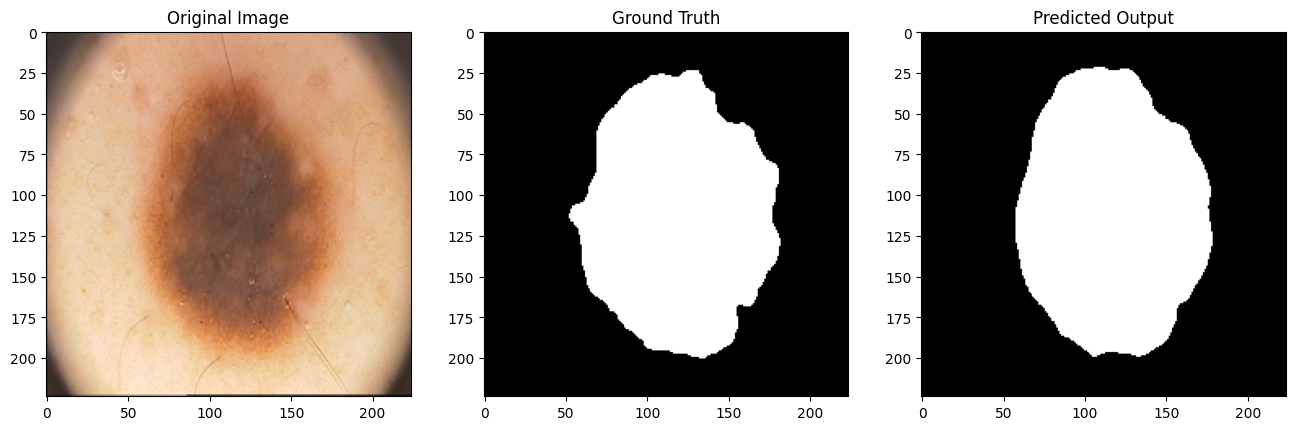

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


# Encode metadata using the same encoders as training
encoded_test_metadata = np.column_stack([
    metadata_encoders[col].transform(med_data_test[col].astype(str)) for col in metadata_columns
])
'''
# Load test images and masks
def load_images_from_folder(folder_path, target_size=(224, 224)):
    images = []
    for filename in sorted(os.listdir(folder_path)):  # Sort to match order with metadata
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, target_size)  # Resize to target size
            images.append(img)
    return np.array(images)

x_test_images = load_images_from_folder(test_x_path) / 255.0  # Normalize to [0, 1]
y_test = load_images_from_folder(test_y_path, target_size=(224, 224))  # Masks do not need normalization
'''
# Test and visualize results
img_num = 4  # Index of the test image to visualize
test_image = X_test[img_num].reshape(1, 224, 224, 3)
test_metadata = [encoded_test_metadata[img_num, i].reshape(1, 1) for i in range(encoded_test_metadata.shape[1])]

# Load the model if needed
# model = load_model('/path/to/saved/model.h5', custom_objects={'jaccard_distance': jaccard_distance})

# Make a prediction
img_pred = model.predict([test_image] + test_metadata)
img_pred1=img_pred>0.5
# Visualize the results
plt.figure(figsize=(16, 16))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(X_test[img_num])
plt.title('Original Image')

# Ground Truth Mask
plt.subplot(1, 3, 2)
plt.imshow(Y_test[img_num], cmap='binary_r')
plt.title('Ground Truth')

# Predicted Mask
plt.subplot(1, 3, 3)
plt.imshow(img_pred1.reshape(224, 224), cmap='binary_r')
plt.title('Predicted Output')

plt.show()


In [ ]:
 x_test=X_test
 y_test=Y_test

In [ ]:
import numpy as np
from tensorflow.keras import backend as K

# Dice and IoU score functions
def dice_score(y_true, y_pred, smooth=1e-6):
    y_true = K.cast(y_true, dtype=K.floatx())
    y_pred = K.cast(y_pred, dtype=K.floatx())
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2. * intersection + smooth) / (union + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    y_true = K.cast(y_true, dtype=K.floatx())
    y_pred = K.cast(y_pred, dtype=K.floatx())
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

# Debug shapes
print("x_test shape:", x_test.shape)
test_metadata_inputs = [encoded_test_metadata[:, i].reshape(-1, 1) for i in range(encoded_test_metadata.shape[1])]
for i, metadata in enumerate(test_metadata_inputs):
    print(f"Metadata input {i} shape:", metadata.shape)

# Predict masks
predictions = model.predict([x_test] + test_metadata_inputs)

# Binarize predictions
predictions_binary = (predictions > 0.5).astype(int)

# Calculate Dice and IoU scores
dice_scores = []
iou_scores = []

for i in range(len(y_test)):
    y_true = y_test[i]
    y_pred_bin = predictions_binary[i]

    y_true_tf = K.constant(y_true, dtype=K.floatx())
    y_pred_bin_tf = K.constant(y_pred_bin, dtype=K.floatx())

    dice = K.eval(dice_score(y_true_tf, y_pred_bin_tf))
    iou = K.eval(iou_score(y_true_tf, y_pred_bin_tf))

    dice_scores.append(dice)
    iou_scores.append(iou)

# Average metrics
average_dice = np.mean(dice_scores)
mean_iou = np.mean(iou_scores)

# Print results
print(f"Average Dice Score over test set: {average_dice:.4f}")
print(f"Mean IoU over test set: {mean_iou:.4f}")


x_test shape: (40, 224, 224, 3)
Metadata input 0 shape: (40, 1)
Metadata input 1 shape: (40, 1)
Metadata input 2 shape: (40, 1)
Metadata input 3 shape: (40, 1)
Metadata input 4 shape: (40, 1)
Metadata input 5 shape: (40, 1)
Metadata input 6 shape: (40, 1)
Metadata input 7 shape: (40, 1)
Metadata input 8 shape: (40, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step
Average Dice Score over test set: 0.9062
Mean IoU over test set: 0.8464


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import backend as K

num_images = 5  # Number of images to visualize

plt.figure(figsize=(20, 20))
for i in range(num_images):
    img_num = i

    # Prepare the test image and metadata inputs
    test_image = x_test[img_num].reshape(1, 224, 224, 3)
    test_metadata = [encoded_test_metadata[img_num, j].reshape(1, 1) for j in range(encoded_test_metadata.shape[1])]

    # Make predictions using the model
    img_pred = model.predict([test_image] + test_metadata)
    pred = img_pred[0]

    # Binarize predictions for comparison
    y_pred_bin = pred.reshape(224, 224) > 0.5
    y_true_bin = y_test[img_num].reshape(224, 224) > 0.5

    # Calculate the Dice score
    y_true_tf = K.constant(y_true_bin, dtype=K.floatx())
    y_pred_tf = K.constant(y_pred_bin, dtype=K.floatx())
    dice = K.eval(dice_score(y_true_tf, y_pred_tf))

    # Plot the original image
    plt.subplot(num_images, 3, i * 3 + 1)
    plt.imshow(x_test[img_num])
    plt.title(f'Original Image {img_num}')

    # Plot the ground truth mask
    plt.subplot(num_images, 3, i * 3 + 2)
    plt.imshow(y_test[img_num], cmap='binary_r')
    plt.title(f'Ground Truth {img_num}')

    # Plot the predicted mask
    plt.subplot(num_images, 3, i * 3 + 3)
    plt.imshow(y_pred_bin, cmap='binary_r')
    plt.title(f'Predicted Output {img_num}\nDice Score: {dice:.4f}')

plt.tight_layout()
plt.show()


NameError: name 'x_test' is not defined

<Figure size 2000x2000 with 0 Axes>

1. MCD version of normal unet
2. Meta-Unet
3. MCD version of meta-Unet
4. Uncertainty analysis of Unet vs Meta-Unet